In [ ]:
# Walmart Sales Forecasting Project
# Google Colab Notebook
# Install required packages
!pip install kaggle plotly xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn


In [ ]:

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb


In [ ]:

# Set up Kaggle API
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d aslanahmedov/walmart-sales-forecast
!unzip walmart-sales-forecast.zip


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast
License(s): copyright-authors
  0% 0.00/3.36M [00:00<?, ?B/s]
100% 3.36M/3.36M [00:00<00:00, 861MB/s]
Archive:  walmart-sales-forecast.zip
  inflating: features.csv            
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               


In [ ]:

# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
stores_data = pd.read_csv('stores.csv')
features_data = pd.read_csv('features.csv')

print("Dataset shapes:")
print(f"Train: {train_data.shape}")
print(f"Test: {test_data.shape}")
print(f"Stores: {stores_data.shape}")
print(f"Features: {features_data.shape}")


Dataset shapes:
Train: (421570, 5)
Test: (115064, 4)
Stores: (45, 3)
Features: (8190, 12)


In [ ]:

# Display basic information about datasets
print("\n=== TRAIN DATA ===")
print(train_data.head())
print("\nTrain data info:")
print(train_data.info())

print("\n=== STORES DATA ===")
print(stores_data.head())

print("\n=== FEATURES DATA ===")
print(features_data.head())

# Data Exploration and Visualization
plt.figure(figsize=(15, 10))



=== TRAIN DATA ===
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

=== STORES DATA ===
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

=

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0, 0.5, 'Average Weekly Sales')

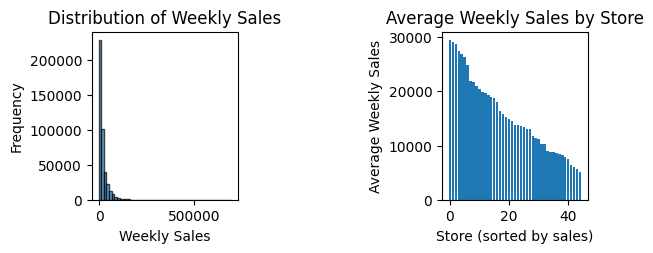

In [ ]:

# Sales distribution
plt.subplot(2, 3, 1)
plt.hist(train_data['Weekly_Sales'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

# Sales by store
plt.subplot(2, 3, 3)
store_sales = train_data.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)
plt.bar(range(len(store_sales)), store_sales.values)
plt.title('Average Weekly Sales by Store')
plt.xlabel('Store (sorted by sales)')
plt.ylabel('Average Weekly Sales')


Text(0.5, 1.0, 'Holiday vs Non-Holiday Sales')

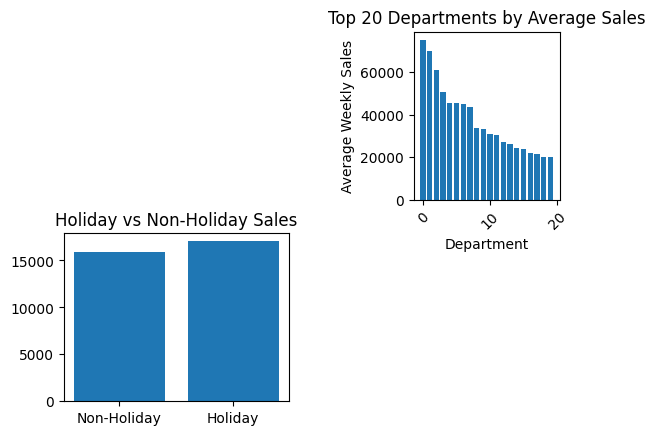

In [ ]:
# Sales by department
plt.subplot(2, 3, 3)
dept_sales = train_data.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).head(20)#there is 99 dept but i only chose 20 departements
plt.bar(range(len(dept_sales)), dept_sales.values)
plt.title('Top 20 Departments by Average Sales')
plt.xlabel('Department')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=45)
# Holiday impact
plt.subplot(2, 2, 3)
holiday_sales = train_data.groupby('IsHoliday')['Weekly_Sales'].mean()
plt.bar(['Non-Holiday', 'Holiday'], holiday_sales.values)
plt.title('Holiday vs Non-Holiday Sales')

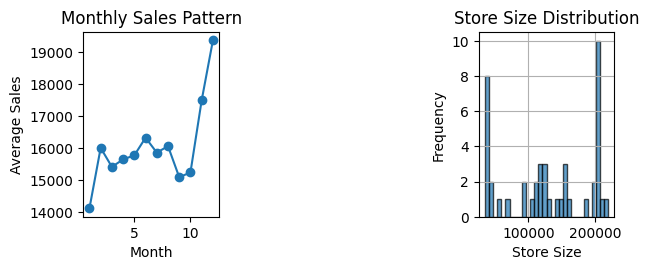

In [ ]:
# Sales over time
plt.subplot(2, 3, 1)
train_data['Date'] = pd.to_datetime(train_data['Date'])
monthly_sales = train_data.groupby(train_data['Date'].dt.month)['Weekly_Sales'].mean()
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title('Monthly Sales Pattern')
plt.xlabel('Month')
plt.ylabel('Average Sales')
# Store size distribution
# note that store size in square feet (sq ft)
plt.subplot(2, 3, 3)
stores_data['Size'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Store Size Distribution')
plt.xlabel('Store Size')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Interactive visualizations with Plotly
# Sales by store over time
train_data['Date'] = pd.to_datetime(train_data['Date'])
monthly_store_sales = train_data.groupby(['Store', train_data['Date'].dt.to_period('M')])['Weekly_Sales'].sum().reset_index()
monthly_store_sales['Date'] = monthly_store_sales['Date'].astype(str)

fig = px.line(monthly_store_sales, x='Date', y='Weekly_Sales', color='Store',
              title='Monthly Sales Trend by Store')
fig.update_xaxes(tickangle=45)
fig.show()


In [ ]:
print("\n=== Data Preprocessing ===")

# Convert dates
features_data['Date'] = pd.to_datetime(features_data['Date'])
#Converts the 'Date' column in the features dataset from string format to proper datetime objects
# Merge all data
df = train_data.merge(stores_data, on='Store', how='left')
df = df.merge(features_data, on=['Store', 'Date', 'IsHoliday'], how='left')
#First merge: Combines the training data with store information using Store ID as the key
#Second merge: Adds features data using Store ID, Date, and IsHoliday as composite keys
# on=['Store', 'Date', 'IsHoliday'] ensures that these are the composite keys ( primary keys)
print(f"Merged data shape: {df.shape}")

# Handle missing values (simple approach)
df = df.fillna(0)  # Fill all missing values with 0

# Feature engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter
# Encode store type
#applying one hot encoding
df['Type_A'] = (df['Type'] == 'A').astype(int)
df['Type_B'] = (df['Type'] == 'B').astype(int)
df['Type_C'] = (df['Type'] == 'C').astype(int)

print("Feature engineering completed!")
# Select features for modeling
# Define features that we want to use
feature_columns = [
    'Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'IsHoliday', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter',
    'Type_A', 'Type_B', 'Type_C'
]

# Add markdown features if they exist
# if i want to to dynamically add markdown features if they exist in the data df
markdown_features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for feature in markdown_features:
    if feature in df.columns:
        feature_columns.append(feature)
# Check which features actually exist in the dataframe
available_features = [col for col in feature_columns if col in df.columns]
missing_features = [col for col in feature_columns if col not in df.columns]

print(f"\nAvailable features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"Missing features ({len(missing_features)}): {missing_features}")




# Use only available features
X = df[available_features]
y = df['Weekly_Sales']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")



=== Data Preprocessing ===
Merged data shape: (421570, 16)
Feature engineering completed!

Available features (21): ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Type_A', 'Type_B', 'Type_C', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

Features shape: (421570, 21)
Target shape: (421570,)


In [ ]:
# Remove rows with NaN values
mask = ~(X.isna().any(axis=1) | y.isna())
#Checks each row in the feature matrix X for any NaN (missing) values |Checks for NaN values in the target variable y
#~(X.isna().any(axis=1) | y.isna()) Inverts the boolean mask so you keep only no NAN values

X = X[mask] # keeps only clean rows from features
y = y[mask] # keeps corresponding target values

print(f"After removing NaN - Features shape: {X.shape}")
print(f"After removing NaN - Target shape: {y.shape}")



After removing NaN - Features shape: (421570, 21)
After removing NaN - Target shape: (421570,)


In [ ]:
# Split data
#I've used train test split so i can avoid overfitting and also in test dataset there is no weekly sales feature also i want to choose the best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (337256, 21)
Test set: (84314, 21)


In [ ]:
# Train models
print("\n=== Model Training ===")

models = {}
predictions = {}

# 1. Linear Regression
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
models['Linear Regression'] = lr
predictions['Linear Regression'] = lr_pred

# 2. Random Forest
print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
models['Random Forest'] = rf
predictions['Random Forest'] = rf_pred

# 3. XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(n_estimators=50, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_pred



=== Model Training ===
Training Linear Regression...
Training Random Forest...
Training XGBoost...


In [ ]:
# Evaluate models
print("\n=== Model Evaluation ===")

results = []
for name, pred in predictions.items():
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

    print(f"{name}:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    print()

# Create results dataframe
results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df.round(4))

# Find best model
best_model_idx = results_df['R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"\nBest Model: {best_model_name}")

# Visualize results
plt.figure(figsize=(15, 5))


=== Model Evaluation ===
Linear Regression:
  MAE: 14561.46
  RMSE: 21753.62
  R2: 0.0925

Random Forest:
  MAE: 1414.53
  RMSE: 3697.53
  R2: 0.9738

XGBoost:
  MAE: 3560.44
  RMSE: 6267.41
  R2: 0.9247

Model Comparison:
               Model         MAE        RMSE      R2
0  Linear Regression  14561.4602  21753.6201  0.0925
1      Random Forest   1414.5267   3697.5263  0.9738
2            XGBoost   3560.4441   6267.4101  0.9247

Best Model: Random Forest


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [ ]:
# Hyperparameter Tuning for the best model
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [10, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid,
                              cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [10, 20],
        'max_depth': [3, 6],

    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                              cv=2, scoring='neg_mean_squared_error', n_jobs=-1)

if best_model_name != 'Linear Regression':
    grid_search.fit(X_train, y_train)
    best_tuned_model = grid_search.best_estimator_
    tuned_pred = best_tuned_model.predict(X_test)

    print("Best parameters:", grid_search.best_params_)
    print("Tuned model performance:")
    print(f"MAE: {mean_absolute_error(y_test, tuned_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, tuned_pred)):.4f}")
    print(f"R2: {r2_score(y_test, tuned_pred):.4f}")



Performing hyperparameter tuning for Random Forest...
Best parameters: {'max_depth': 6, 'n_estimators': 10}
Tuned model performance:
MAE: 7342.5302
RMSE: 12183.9305
R2: 0.7153


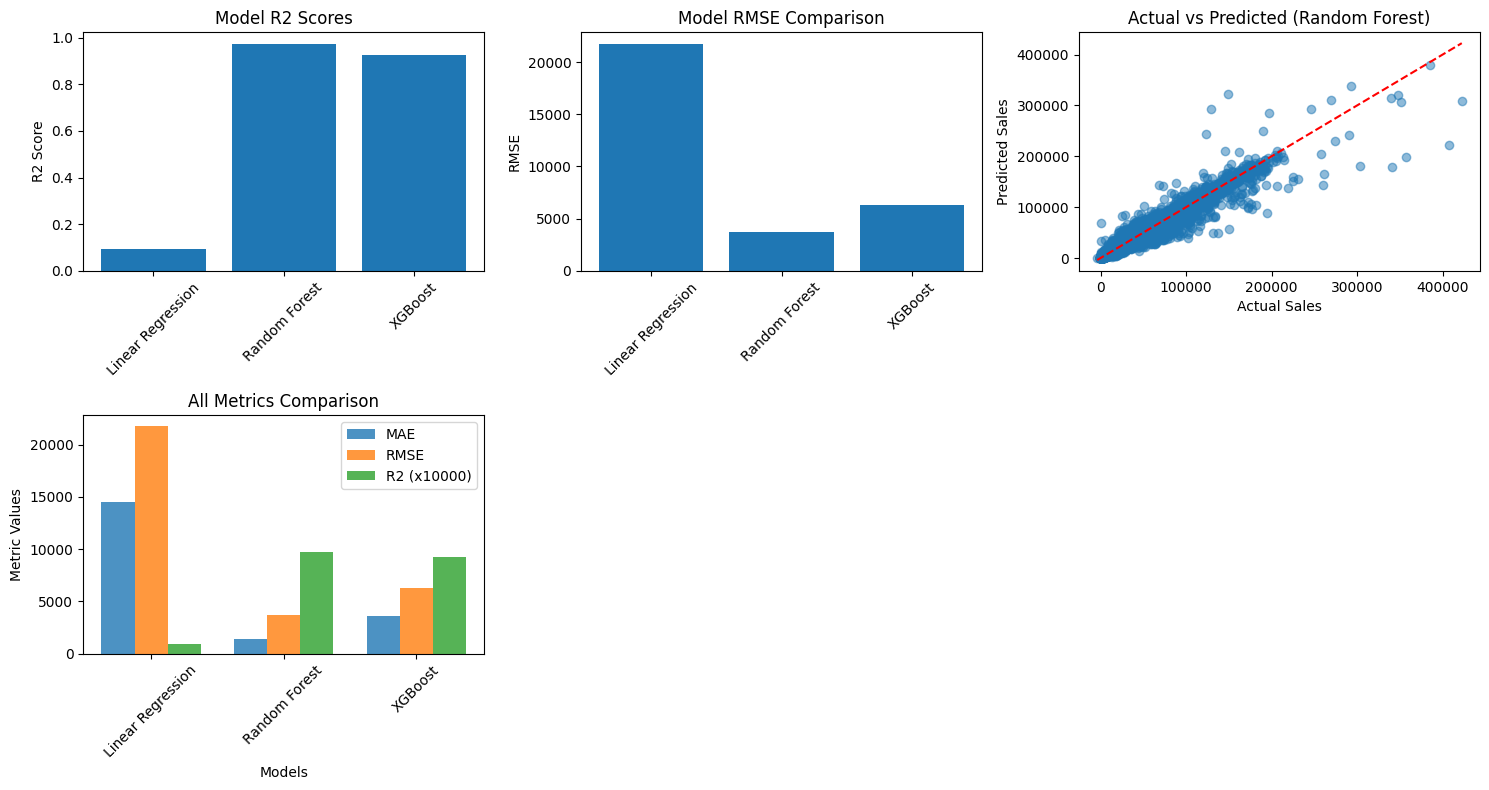

<Figure size 800x600 with 0 Axes>

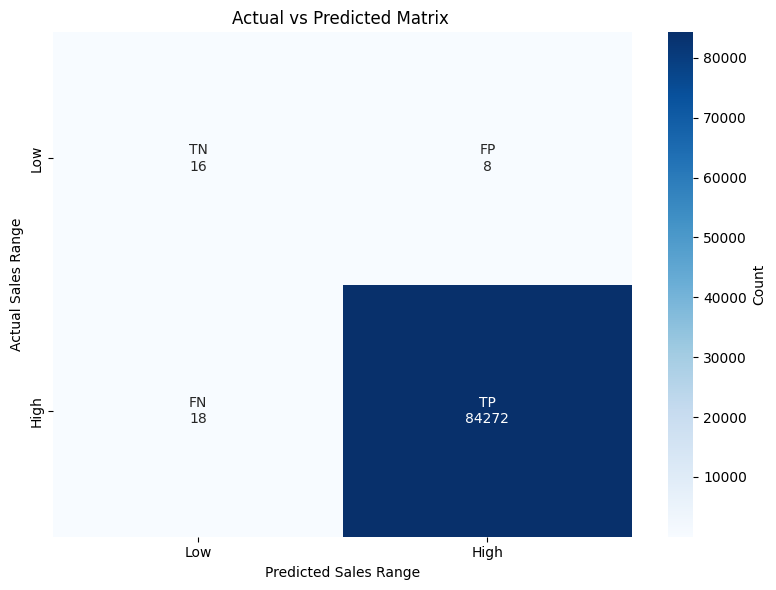

In [ ]:
# Model comparison with enhanced visualizations
plt.figure(figsize=(15, 8))

# 1. Model R2 Scores
plt.subplot(2, 3, 1)
plt.bar(results_df['Model'], results_df['R2'])
plt.title('Model R2 Scores')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)

# 2. Model RMSE Comparison
plt.subplot(2, 3, 2)
plt.bar(results_df['Model'], results_df['RMSE'])
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# 3. Actual vs Predicted
plt.subplot(2, 3, 3)
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted ({best_model_name})')

# 4. Model Performance Comparison (All Metrics)
plt.subplot(2, 3, 4)
metrics = ['MAE', 'RMSE', 'R2']
x_pos = np.arange(len(results_df))
width = 0.25

for i, metric in enumerate(metrics):
    if metric == 'R2':
        # Scale R2 to make it visible with other metrics
        values = results_df[metric] * 10000  # Scale for visibility
        label = f'{metric} (x10000)'
    else:
        values = results_df[metric]
        label = metric

    plt.bar(x_pos + i*width, values, width, label=label, alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('All Metrics Comparison')
plt.xticks(x_pos + width, results_df['Model'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Separate plot for simplified prediction matrix (2x2)
plt.figure(figsize=(8, 6))
# Create simplified 2x2 bins for actual and predicted values
n_bins = 2
actual_bins = pd.cut(y_test, bins=n_bins, labels=['Low', 'High'])
pred_bins = pd.cut(best_predictions, bins=n_bins, labels=['Low', 'High'])

# Create confusion matrix for binned values
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_bins, pred_bins)

# Extract TP, TN, FP, FN values
tn, fp, fn, tp = conf_matrix.ravel()

# Create annotations with TP, TN, FP, FN labels
annotations = np.array([
    [f'TN\n{tn}', f'FP\n{fp}'],
    [f'FN\n{fn}', f'TP\n{tp}']
])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap='Blues',
           xticklabels=['Low', 'High'],
           yticklabels=['Low', 'High'],
           cbar_kws={'label': 'Count'})

plt.xlabel('Predicted Sales Range')
plt.ylabel('Actual Sales Range')
plt.title('Actual vs Predicted Matrix ')



plt.tight_layout()
plt.show()



In [ ]:
# Business insights
print("\n=== Business Insights ===")

# Top performing stores
print("Top 5 Stores by Average Sales:")
top_stores = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).head(5)
for store, sales in top_stores.items():
    print(f"Store {store}: ${sales:,.0f}")

# Department performance
print("\nTop 5 Departments by Average Sales:")
top_depts = df.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).head(5)
for dept, sales in top_depts.items():
    print(f"Department {dept}: ${sales:,.0f}")

# Holiday impact
holiday_avg = df.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_boost = ((holiday_avg[True] - holiday_avg[False]) / holiday_avg[False]) * 100
print(f"\nHoliday Impact: {holiday_boost:.1f}% increase in sales")

# Monthly trends
monthly_avg = df.groupby('Month')['Weekly_Sales'].mean()
best_month = monthly_avg.idxmax()
worst_month = monthly_avg.idxmin()
print(f"Best performing month: {best_month}")
print(f"Worst performing month: {worst_month}")




=== Business Insights ===
Top 5 Stores by Average Sales:
Store 20: $29,508
Store 4: $29,161
Store 14: $28,785
Store 13: $27,355
Store 2: $26,898

Top 5 Departments by Average Sales:
Department 92: $75,205
Department 95: $69,824
Department 38: $61,091
Department 72: $50,567
Department 65: $45,442

Holiday Impact: 7.1% increase in sales
Best performing month: 12
Worst performing month: 1


In [ ]:
# Store feature names for prediction function
feature_names = available_features.copy()
print(f"\nModel trained on {len(feature_names)} features:")
print(feature_names)

# Save the best model and feature names
import pickle
model_data = {
    'model': best_model,
    'feature_names': feature_names,
    'model_name': best_model_name
}

with open('walmart_sales_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)
print(f"\nModel saved as 'walmart_sales_model.pkl'")



Model trained on 21 features:
['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Type_A', 'Type_B', 'Type_C', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

Model saved as 'walmart_sales_model.pkl'


In [ ]:

# Simple prediction function
def predict_sales(store, dept, size, temperature, fuel_price, cpi=0, unemployment=0,
                 is_holiday=False, year=2023, month=1, day=1, dayofweek=1, quarter=1,
                 type_a=1, type_b=0, type_c=0, markdown1=0, markdown2=0,
                 markdown3=0, markdown4=0, markdown5=0):
    """
    Function to make sales predictions with correct feature count
    """
    # Create input array matching the exact features used in training
    input_values = []

    # Add features in the same order as feature_names
    feature_dict = {
        'Store': store,
        'Dept': dept,
        'Size': size,
        'Temperature': temperature,
        'Fuel_Price': fuel_price,
        'CPI': cpi,
        'Unemployment': unemployment,
        'IsHoliday': int(is_holiday),
        'Year': year,
        'Month': month,
        'Day': day,
        'DayOfWeek': dayofweek,
        'Quarter': quarter,
        'Type_A': type_a,
        'Type_B': type_b,
        'Type_C': type_c,
        'MarkDown1': markdown1,
        'MarkDown2': markdown2,
        'MarkDown3': markdown3,
        'MarkDown4': markdown4,
        'MarkDown5': markdown5
    }

    # Build input array in correct order
    for feature in feature_names:
        input_values.append(feature_dict.get(feature, 0))

    # Create numpy array and reshape for prediction
    sample_input = np.array(input_values).reshape(1, -1)

    print(f"Input shape: {sample_input.shape}")
    print(f"Expected features: {len(feature_names)}")

    prediction = best_model.predict(sample_input)[0]
    return prediction

# Example prediction
# Basic prediction
example_prediction = predict_sales(
    store=1, dept=1, size=151315, temperature=42.31, fuel_price=2.572,
    is_holiday=False
)
print(f"Basic prediction: ${example_prediction:,.2f}")

# Holiday prediction
holiday_prediction = predict_sales(
    store=1, dept=1, size=151315, temperature=42.31, fuel_price=2.572,
    is_holiday=True
)
print("****Second example for holiday****")
print(f"Holiday prediction: ${holiday_prediction:,.2f}")

# Large store prediction
large_store_prediction = predict_sales(
    store=20, dept=1, size=200000, temperature=70.0, fuel_price=3.0,
    is_holiday=False
)
print("****Third example for large stores****")
print(f"Large store prediction: ${large_store_prediction:,.2f}")



Input shape: (1, 21)
Expected features: 21
Basic prediction: $27,922.00
Input shape: (1, 21)
Expected features: 21
****Second example for holiday****
Holiday prediction: $33,562.04
Input shape: (1, 21)
Expected features: 21
****Third example for large stores****
Large store prediction: $26,743.61
